In [469]:
import pandas as pd
import numpy as np
from joblib import dump

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import label_binarize
from sklearn import svm

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# geospatial
import geopandas as gpd
import earthpy.plot as ep
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
import folium

In [331]:
train_data = 'C:/Users/DELL/Downloads/RS&GIS_Stuff/Agriculture Land Conservation/Results/train_output.csv'
validation_data = 'C:/Users/DELL/Downloads/RS&GIS_Stuff/Agriculture Land Conservation/Results/validation_output.csv'
results = 'C:/Users/DELL/Downloads/RS&GIS_Stuff/Agriculture Land Conservation/Results/'
# path to collocated and preprocesed image
s2_img = "C:/Users/DELL/Downloads/RS&GIS_Stuff/Agriculture Land Conservation/Processed Data/image2.tif"
roi = "C:/Users/DELL/Downloads/RS&GIS_Stuff/Agriculture Land Conservation/Processed Data/Iwo.shp"
bands = [
        'B2_1', 'B3_1', 'B4_1', 'B8_1', 'B','B12_1' ,
    'B2_2', 'B3_2', 'B4_2', 'B8_2', 'B11_2','B12_2',
    'B2_3', 'B3_3', 'B4_3', 'B8_3', 'B11_3','B12_3',
     'B2_4', 'B3_4', 'B4_4', 'B8_4', 'B11_4','B12_4',
     'B2_5', 'B3_5', 'B4_5', 'B8_5', 'B11_5', 'B12_5',
     'B2_6', 'B3_6', 'B4_6', 'B8_6', 'B11_6', 'B12_6',
     'B2_7', 'B3_7', 'B4_7', 'B8_7', 'B11_7', 'B12_7',
     'B2_8', 'B3_8', 'B4_8', 'B8_8', 'B11_8', 'B12_8',
     'B2_9', 'B3_9', 'B4_9', 'B8_9', 'B11_9', 'B12_9',
        ]
class_name = ['Water Bodies', 'Trees', 'Crops', 'Built up Areas',
             'Rangeland', ]
lulc_colors = {
    'Water Bodies': '#0000FF',     # Blue
    'Trees': '#228B22',           # Forest Green
    'Crops': '#FFD700',          # Golden Yellow
    'Built up Areas': '#FF0000',  # Red
    # 'Bareland': '#DEB887',       # Burlywood (Light Brown)
    'Rangeland': '#98FB98'       # Pale Green
}

In [335]:
train = pd.read_csv(train_data)
train.sample(5).T

test = pd.read_csv(validation_data)
test.sample(5).T

,71,175,354,49,98
label,4.0,2.0,6.0,2.0,6.0
B2_1,1261.0,1150.0,1160.0,1122.0,1162.0
B3_1,1157.0,1060.0,1004.0,946.0,995.0
B4_1,1177.0,936.0,866.0,775.0,957.0
B8_1,2320.0,2261.0,2223.0,2268.0,1659.0
B,2481.0,2122.0,1597.0,1708.0,2042.0
B12_1,1578.0,1209.0,788.0,830.0,1297.0
B22,1920.0,1873.0,1935.0,1852.0,1875.0
B3_2,1795.0,1730.0,1781.0,1688.0,1715.0
B4_2,1802.0,1716.0,1728.0,1633.0,1669.0


In [322]:
X_train = train.drop(columns=['class'])
y_train = train['class'].tolist()

In [341]:
X_test = test.drop(columns=['label'])
y_test = test['label'].tolist()

# Train Preparation 

In [344]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

## Model definition and training 

In [400]:
rf = RandomForestClassifier(n_estimators=300, oob_score=True,max_features='sqrt')
rf.fit(X_train,y_train)
rf.oob_score_

0.8411214953271028

In [401]:
# compute score
score = rf.score(X_test, y_test)
print('Average accuracy score: {}'.format(score))
scoreAvg = np.asarray(score).mean()
print('Average accuracy score: {}'.format(scoreAvg))

Average accuracy score: 0.8263473053892215
Average accuracy score: 0.8263473053892215


## Model Validation

### Probability Distribution of Prediction 

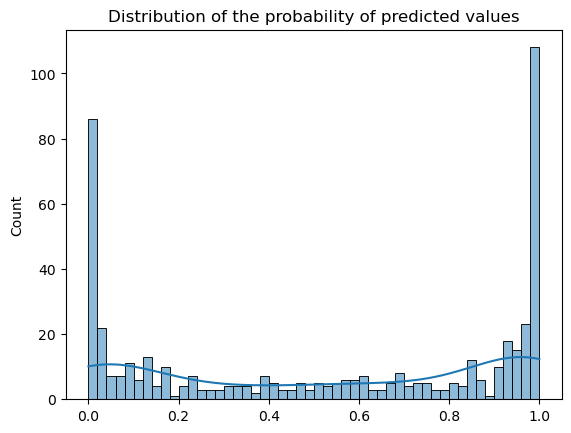

In [452]:
train_predictions = rf.predict(X_train)
test_predictions = rf.predict(X_test)
prediction_probs = rf.predict_proba(X_test)

predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)

sns.histplot(predictionProbabilityArray, bins=50, kde=50)
plt.title('Distribution of the probability of predicted values')
plt.savefig(f'{results}images/rf_pro_distr.png');

### Classification Report 

In [396]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred, target_names=class_name, zero_division=0))
# print('**' *20)
print('--' *10, 'cm', '--'*10)
print(cm)

                precision    recall  f1-score   support

  Water Bodies       0.00      0.00      0.00         2
         Trees       0.87      0.90      0.88       272
         Crops       0.50      0.14      0.22         7
Built up Areas       0.82      0.75      0.78        71
     Rangeland       0.73      0.76      0.75       149

      accuracy                           0.82       501
     macro avg       0.58      0.51      0.53       501
  weighted avg       0.81      0.82      0.82       501

-------------------- cm --------------------
[[  0   0   0   2   0]
 [  0 244   0   1  27]
 [  0   0   1   4   2]
 [  0   6   0  53  12]
 [  0  30   1   5 113]]


## Classify the Image with the trained Random Forest Model

In [366]:
src = rasterio.open(s2_img)
# read the data to 3 dimensions array
stacked = src.read()
stacked.shape
reshape_img = reshape_as_image(stacked)
# reshape to 2D array
band = [bands.index(l) for l in bands if 'B' in l][0]

In [367]:
reshape_img.shape

(1912, 2211, 54)

In [436]:
# Reshape the Input Data
class_input = reshape_img.reshape(1912*2211, 54)
class_input.shape

#Predict with a Random Forest Model
rf_s = rf
class_rf_s = rf_s.predict(class_input)

# Reshap Predictions Back to Image Shape
class_rf_s = class_rf_s.reshape(reshape_img[:,:,0].shape)

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Visualize 

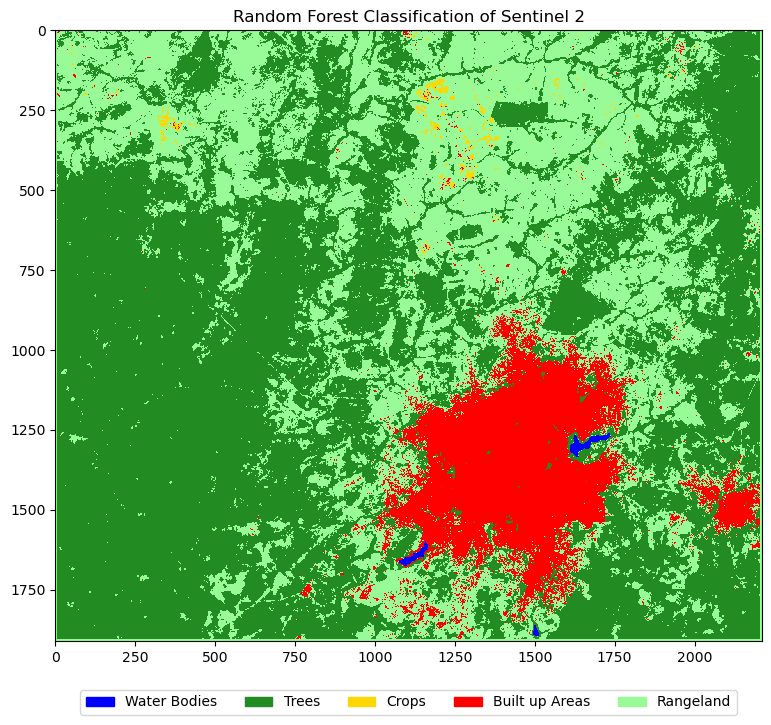

<Figure size 640x480 with 0 Axes>

In [448]:
# Create a colormap from the colors
colors_list = list(lulc_colors.values())
lulc_cmap = plt.cm.colors.ListedColormap(colors_list)

# Create the figure
plt.figure(figsize=(8, 12))

plt.imshow(class_rf_s, 
          cmap=lulc_cmap,
          interpolation='none')

# Add title
plt.title('Random Forest Classification of Sentinel 2')

# Create a legend
patches = [mpatches.Patch(color=colors_list[i], label=class_name[i]) for i in range(len(class_name))]
plt.legend(handles=patches, bbox_to_anchor=(0.5,-0.1), loc='center', ncol=5)
plt.tight_layout()
plt.show()
plt.savefig(f'{results}images/rf_classiication.png');

In [398]:
# Save to raster file
output_raster_path = "classified_image.tif"
with rasterio.Env():
    profile = src.profile
    profile.update(dtype=rasterio.uint8,compression='lzw', count=1)
    with rasterio.open(f'{results}{output_raster_path}', 'w', **profile) as dst:
        dst.write(class_rf_s.astype(rasterio.uint8),1)

## Support Vector Machine

### Training Support Vector Machine Model

In [421]:
svm_model = svm.SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [423]:
# compute score
score = svm_model.score(X_test, y_test)
print('Average accuracy score: {}'.format(score))
scoreAvg = np.asarray(score).mean()
print('Average accuracy score: {}'.format(scoreAvg))

Average accuracy score: 0.8163672654690619
Average accuracy score: 0.8163672654690619


### SVM Model Validatin

### Probability Distribution of Prediction and CLassification Report

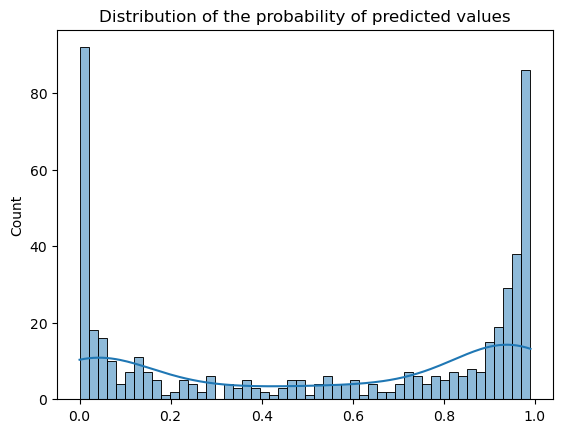

In [431]:
train_predictions = svm_model.predict(X_train)
test_predictions = svm_model.predict(X_test)
prediction_probs = svm_model.predict_proba(X_test)

predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)

sns.histplot(predictionProbabilityArray, bins=50, kde=True)
plt.title('Distribution of the probability of predicted values')
plt.savefig(f'{results}images/svm_pro_distr.png');

In [433]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred, target_names=class_name, zero_division=0))
# print('**' *20)
print('--' *10, 'cm', '--'*10)
print(cm)

                precision    recall  f1-score   support

  Water Bodies       1.00      0.50      0.67         2
         Trees       0.86      0.91      0.89       272
         Crops       0.00      0.00      0.00         7
Built up Areas       0.96      0.62      0.75        71
     Rangeland       0.70      0.79      0.74       149

      accuracy                           0.82       501
     macro avg       0.70      0.56      0.61       501
  weighted avg       0.82      0.82      0.81       501



In [ ]:
## Save 

# Classify the Image with SVM

In [440]:
# Reshap the Input Data
class_input = reshape_img.reshape(1912*2211, 54)
class_input.shape

#Predict with a Random Forest Model
svm_s = svm_model
class_svm_s = svm_s.predict(class_input)

# Reshap Predictions Back to Image Shape
class_svm_s = class_svm_s.reshape(reshape_img[:,:,0].shape)

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


## Visualize

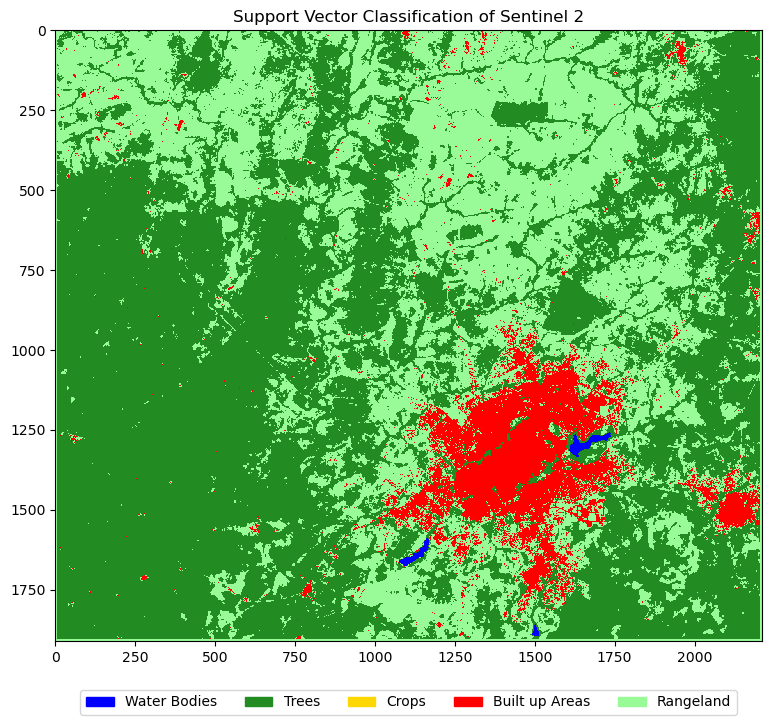

<Figure size 640x480 with 0 Axes>

In [454]:
# Create a colormap from the colors
colors_list = list(lulc_colors.values())
lulc_cmap = plt.cm.colors.ListedColormap(colors_list)

# Create the figure
plt.figure(figsize=(8, 12))

plt.imshow(class_svm_s, 
          cmap=lulc_cmap,
          interpolation='none')

# Add title
plt.title('Support Vector Classification of Sentinel 2')

# Create a legend
patches = [mpatches.Patch(color=colors_list[i], label=class_name[i]) for i in range(len(class_name))]
plt.legend(handles=patches, bbox_to_anchor=(0.5,-0.1), loc='center', ncol=5)
plt.tight_layout()
plt.show()
plt.savefig(f'{results}images/rf_classiication.png');

## Export

In [456]:
# Save to raster file
output_raster_path = "classified_image_SVM.tif"
with rasterio.Env():
    profile = src.profile
    profile.update(dtype=rasterio.uint8,compression='lzw', count=1)
    with rasterio.open(f'{results}{output_raster_path}', 'w', **profile) as dst:
        dst.write(class_svm_s.astype(rasterio.uint8),1)

# Save Both Models

In [476]:
dump(rf_s,f"{results}rfmodel.sav", compress=3)
dump(svm_model,f"{results}svmmodel.sav", compress=3)

['C:/Users/DELL/Downloads/RS&GIS_Stuff/Agriculture Land Conservation/Results/svmmodel.sav']